## Latent Distribution Two-Graph Testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(8888)

from graspologic.inference import latent_distribution_test
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot

%matplotlib inline

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate a stochastic block model graph

We generate a 2-block stochastic blockmodel (SBM) graph and embed it using Adjacency Spectral Embedding (ASE).

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


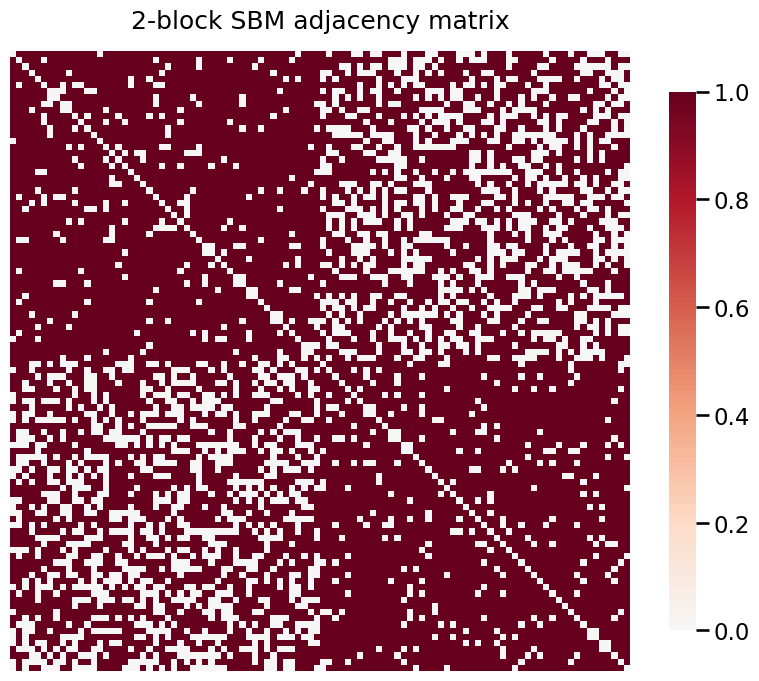

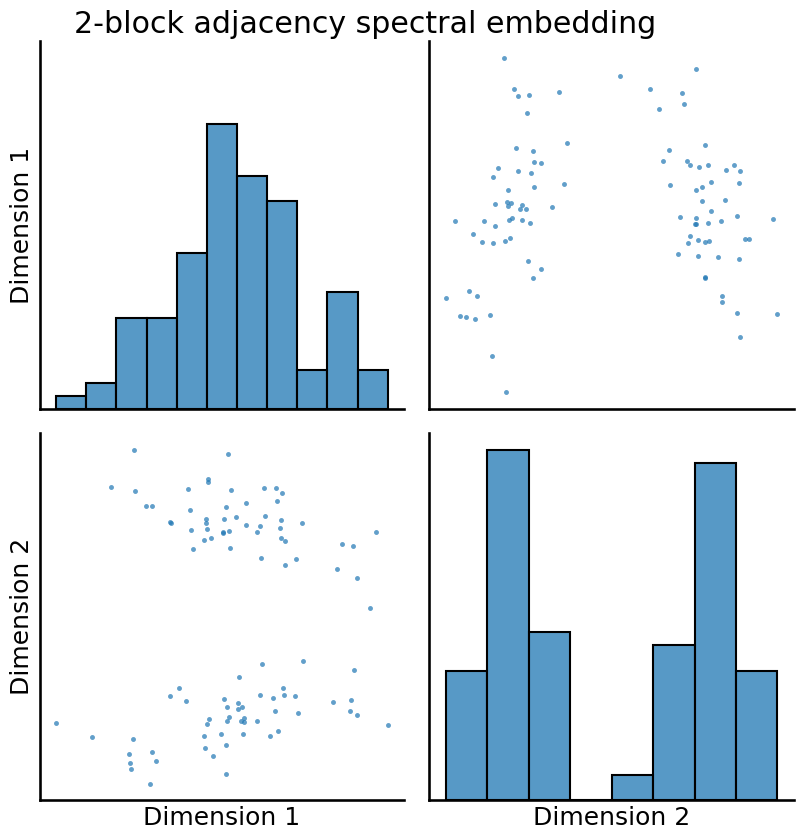

In [2]:
n_components = 2 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.6],
              [0.6, 0.9]])
csize = [50] * 2
A1 = sbm(csize, P)
X1 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A1)
heatmap(A1, title='2-block SBM adjacency matrix')
_ = pairplot(X1, title='2-block adjacency spectral embedding', height=4.5)

We generate a second SBM with a different number of vertices in each block, but with the same probability matrix.

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


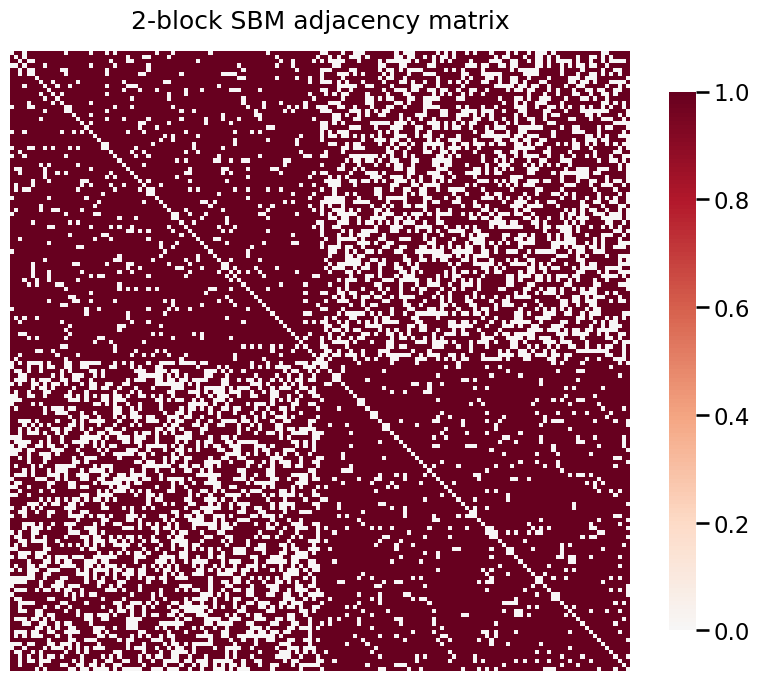

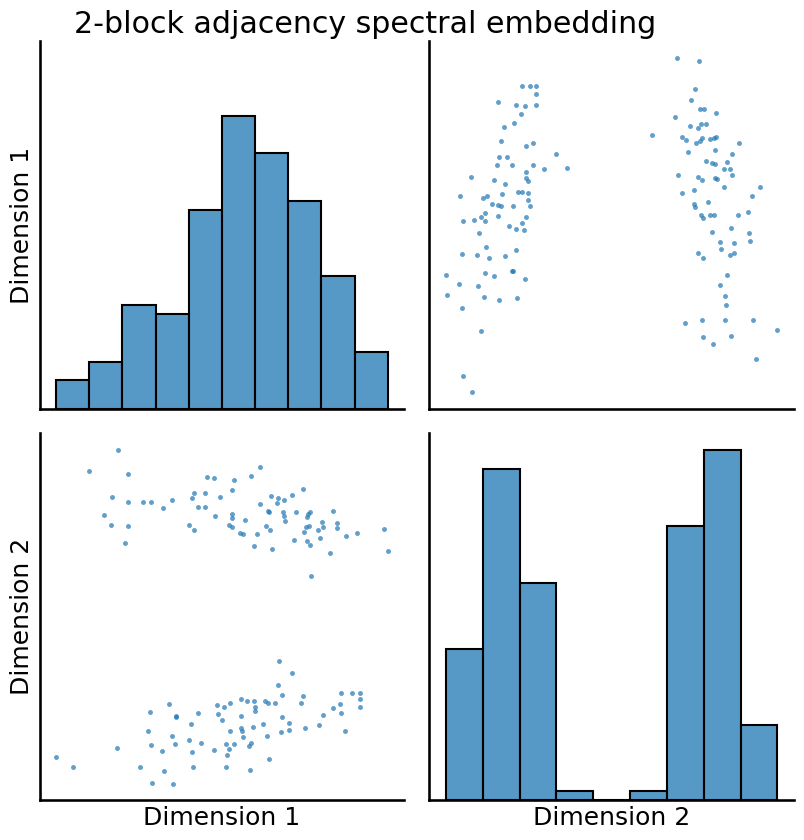

In [3]:
csize_2 = [75] * 2
A2 = sbm(csize_2, P)
X2 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A2)

heatmap(A2, title='2-block SBM adjacency matrix')
_ = pairplot(X2, title='2-block adjacency spectral embedding', height=4.5)

### Latent distribution test where null is true
We want to know whether the latent positions of the two graphs above were generated from the same latent distribution. In other words, we are testing

$$ H_0:F_{X_1} = F_{X_2} Q$$$$ H_\alpha: F_{X_1} \neq F_{X_2} Q $$ 

The $Q$ is an orthogonal rotation matrix present due to the orthogonal non-identifiability in the random dot product graphs.

We know that in this case the graphs were actually generated from the same distribution, so the test should reject no more often than the significance level $\alpha$, and on average the $p$-value should be high (fail to reject the null).

In this tutorial, we will use the latent distribution test on unmatched graphs. This means there is not an alignment between each node of the two graphs.

### Plots of Null Distribution for Dcorr and MGC

The class supports the following independence tests documented [here](https://hyppo.neurodata.io/reference/independence.html), as well as any distance function.

We plot the null distribution (blue), test statistic (red), and p-value (title) of the Dcorr and MGC independence tests using euclidean distance.

In [4]:
ldt_dcorr = latent_distribution_test(A1, A2, test="dcorr", metric="euclidean", n_bootstraps=100)

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/hyppo/tools/common.py:72: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)


In [5]:
ldt_mgc = latent_distribution_test(A1, A2, test="mgc", metric="euclidean", n_bootstraps=100)

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/hyppo/tools/common.py:72: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/hyppo/independence/mgc.py:236: RuntimeWarning: Input x has 0 redundant rows, and input y has 248 redundant rows. MGC Map will be of shape (250, 2).
  warnings.warn(


In [6]:
print(ldt_dcorr[1], ldt_mgc[1])

0.9405940594059405 0.9702970297029703


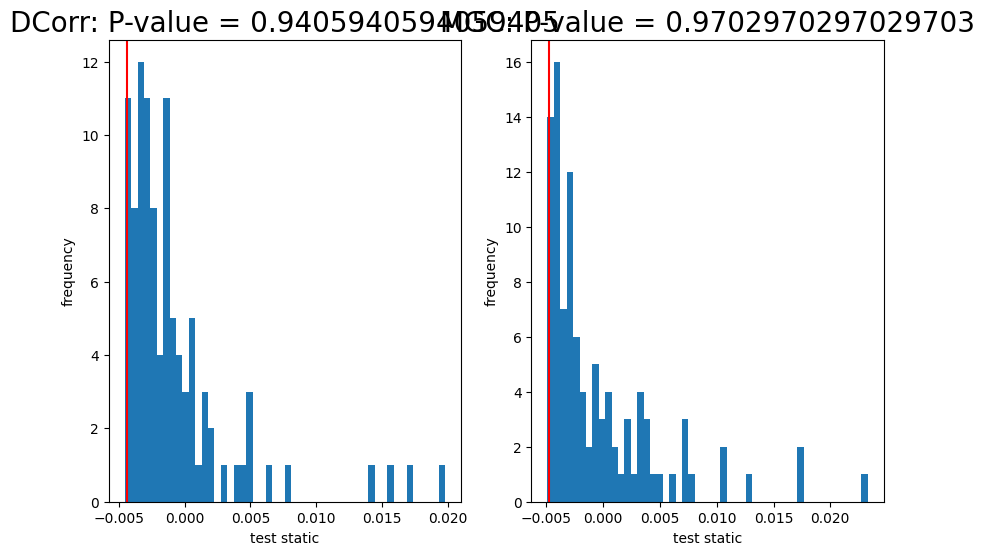

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(ldt_dcorr[2]['null_distribution'], 50)
ax[0].axvline(ldt_dcorr[0], color='r')
ax[0].set_title("DCorr: P-value = {}".format(ldt_dcorr[1]), fontsize=20)
ax[0].set_xlabel("test static")
ax[0].set_ylabel("frequency")
ax[1].hist(ldt_mgc[2]['null_distribution'], 50)
ax[1].axvline(ldt_mgc[0], color='r')
ax[1].set_title("MGC: P-value = {}".format(ldt_mgc[1]), fontsize=20)
ax[1].set_xlabel("test static")
ax[1].set_ylabel("frequency")
plt.show();

We see that the test static is small, resulting in p-values above 0.05. Thus, we cannot reject the null hypothesis that the two graphs come from the same generating distributions.

### Latent distribution test where null is false

We generate a third SBM with different interblock probability, and run a latent distribution test comaring the first graph with the new one.

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


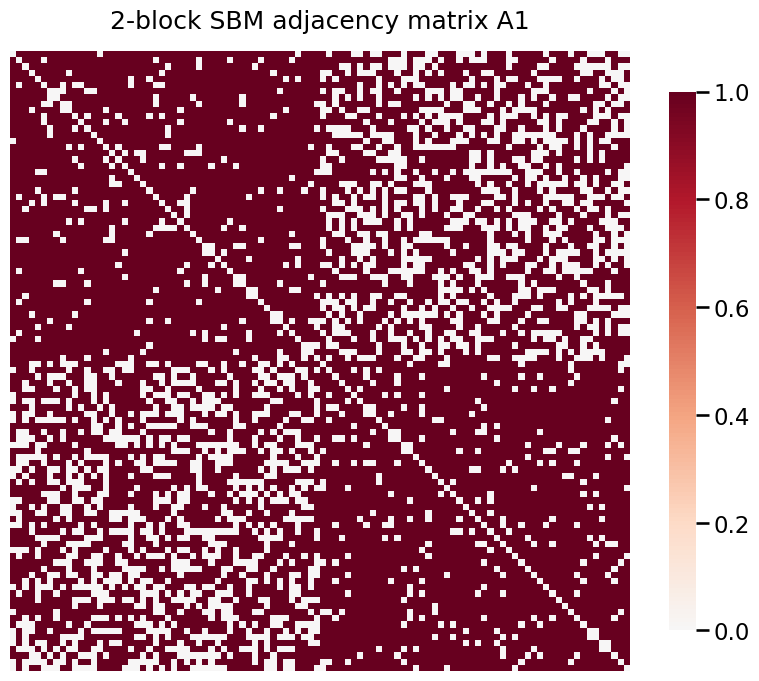

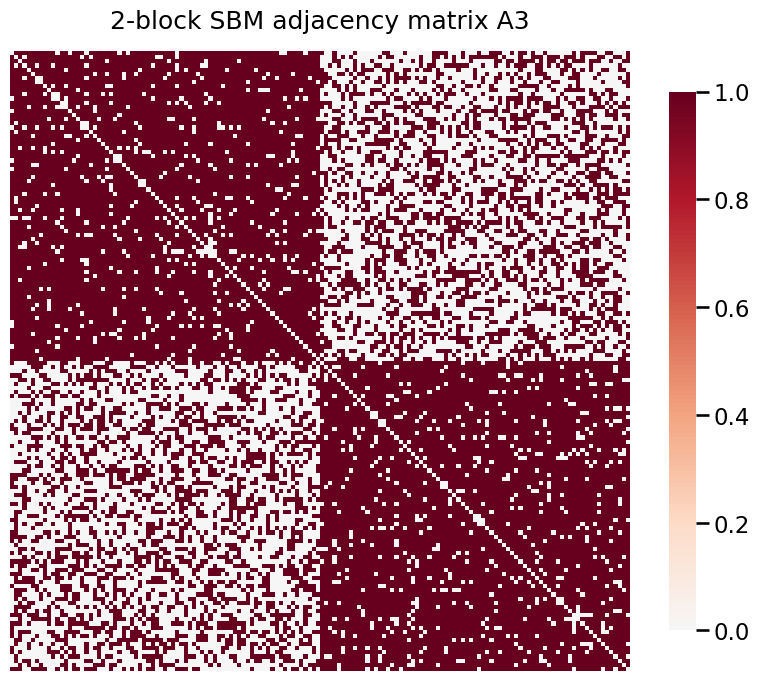

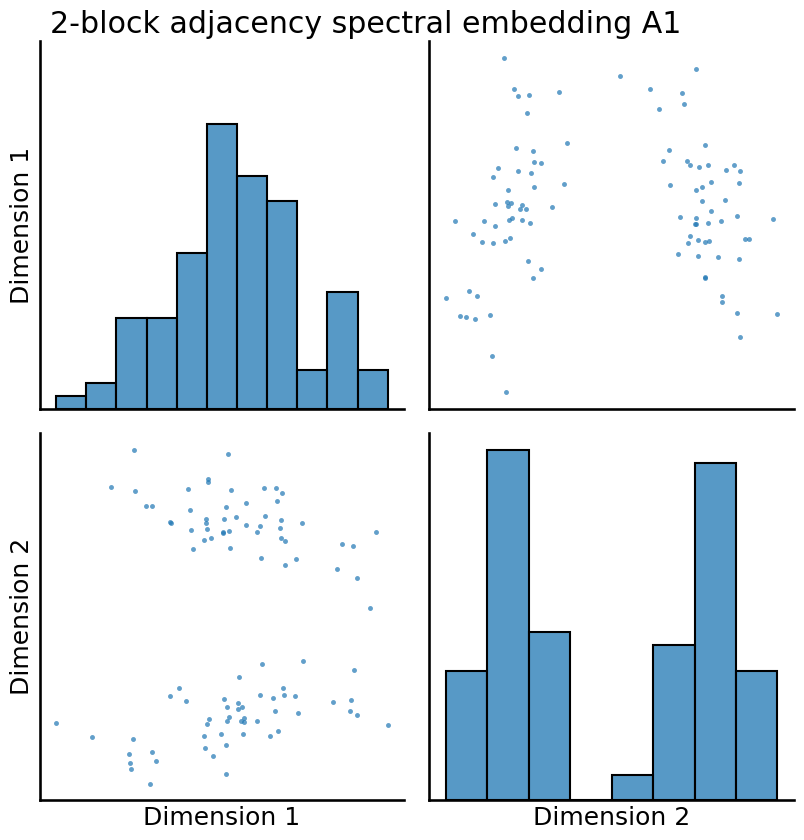

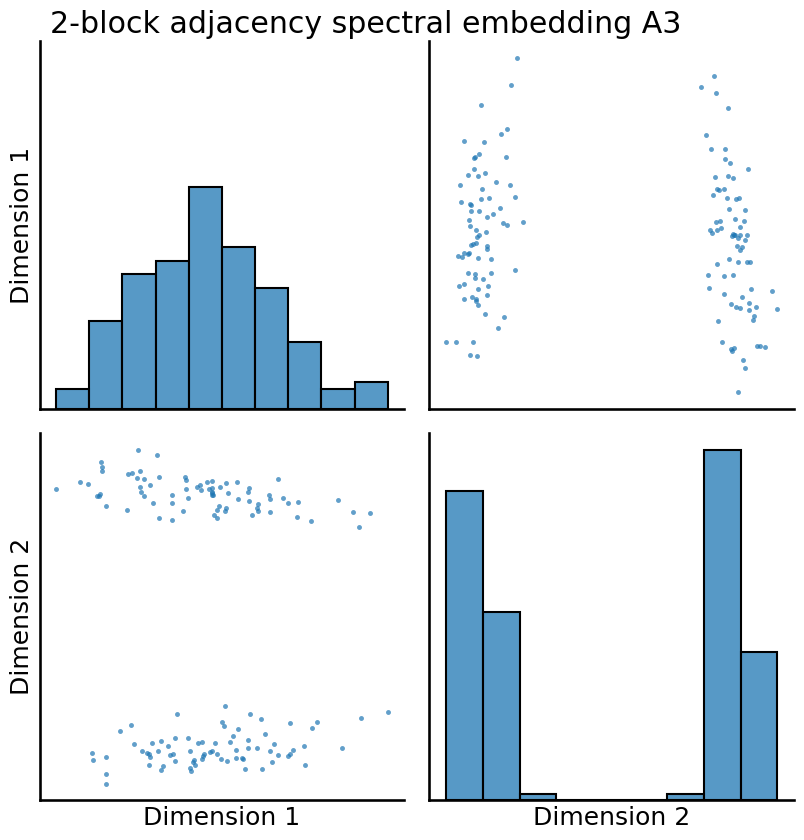

In [8]:
P2 = np.array([[0.9, 0.4],
               [0.4, 0.9]])

A3 = sbm(csize_2, P2)

X1 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A1)
X3 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A3)
heatmap(A1, title='2-block SBM adjacency matrix A1')
heatmap(A3, title='2-block SBM adjacency matrix A3')
pairplot(X1, title='2-block adjacency spectral embedding A1', height=4.5)
_ = pairplot(X3, title='2-block adjacency spectral embedding A3', height=4.5)

### Plot of Null Distribution

We plot the null distribution shown in blue and the test statistic shown red vertical line. We see that the test static is small, resulting in p-value of 0. Thus, we reject the null hypothesis that the two graphs come from the same generating distributions.

In [9]:
ldt_dcorr = latent_distribution_test(A1, A3, test="dcorr", metric="euclidean", n_bootstraps=100)

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/hyppo/tools/common.py:72: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)


In [10]:
ldt_mgc = latent_distribution_test(A1, A3, test="mgc", metric="euclidean", n_bootstraps=100)

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/hyppo/tools/common.py:72: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/hyppo/independence/mgc.py:236: RuntimeWarning: Input x has 0 redundant rows, and input y has 248 redundant rows. MGC Map will be of shape (250, 2).
  warnings.warn(


In [11]:
print(ldt_dcorr[1], ldt_mgc[1])

0.019801980198019802 0.009900990099009901


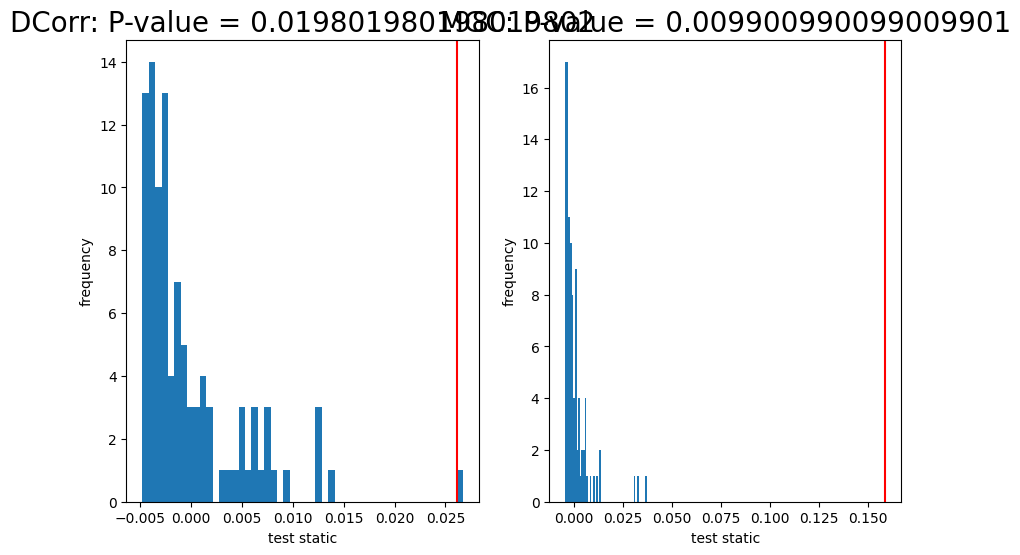

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(ldt_dcorr[2]['null_distribution'], 50)
ax[0].axvline(ldt_dcorr[0], color='r')
ax[0].set_title("DCorr: P-value = {}".format(ldt_dcorr[1]), fontsize=20)
ax[0].set_xlabel("test static")
ax[0].set_ylabel("frequency")
ax[1].hist(ldt_mgc[2]['null_distribution'], 50)
ax[1].axvline(ldt_mgc[0], color='r')
ax[1].set_title("MGC: P-value = {}".format(ldt_mgc[1]), fontsize=20)
ax[1].set_xlabel("test static")
ax[1].set_ylabel("frequency")
plt.show();